In [23]:
from datetime import datetime
import requests
import json
from gql import gql, Client
import pandas as pd
import time
import numpy as np
from sys import argv
import yfinance

from gql.transport.requests import RequestsHTTPTransport

import get_marketplace_data as gmd
import importlib
importlib.reload(gmd)

<module 'get_marketplace_data' from '/Users/fliou/python_projects/decentraland_playground/get_marketplace_data.py'>

In [ ]:

gmd.get_parcels_from_estate('roads','0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce')
gmd.get_parcels_from_estate('genesis','0x4eac6325e1dbf1ac90434d39766e164dca71139e',9)


In [ ]:
0x959e104e1a4db6317fa58f8295f586e1a978c297
0x4eac6325e1dbf1ac90434d39766e164dca71139e

In [3]:
gmd.get_parcels_from_estate('district_x','0x49907511bdf0351daa417a87d349060876a42544')


estate 1 done, 2001 parcels found


In [4]:
gmd.get_parcels_from_estate('DU', '0x71f54536695fc79061bdbf41f8ea54a41cf88108')

estate 1 done, 1502 parcels found


In [5]:
gmd.get_parcels_from_estate('DC', '0x6531411be222a663431bde42da60daeb669ccba2')

estate 1 done, 799 parcels found


In [6]:
gmd.get_parcels_from_estate('sciartlab', '0xe13b048f59781e366789f8725acc1786b6aecc9b')

estate 1 done, 125 parcels found


In [7]:
gmd.get_parcels_from_estate('casino', '0xa65be351527ebcf8c1707d1e444dac38b41a5faf')

estate 1 done, 1575 parcels found
estate 2 done, 1229 parcels found
estate 3 done, 1086 parcels found
estate 4 done, 1230 parcels found


In [2]:
# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://api.thegraph.com/subgraphs/name/decentraland/marketplace")
# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

# Get MANA price

In [2]:
import yfinance
df = yfinance.download('MANA-USD')

[*********************100%***********************]  1 of 1 completed


In [ ]:
from time import sleep
while True:
    sleep(300)

In [8]:
df.to_csv('MANA-USD.csv',index=False)

# Get Estates currently on sale

In [3]:
mystring = """ {{
  orders(
    first: 1000
    orderBy: updatedAt
    orderDirection: asc
    subgraphError: allow
    where: {{status: open, updatedAt_gt:"{0}", expiresAt_gt: "{1}", category: estate}}
  ) {{
    id
    price
    updatedAt
    createdAt
    expiresAt
    owner
    nft {{
      estate {{
        id
        parcels{{
            id
            x
            y
        }}
      }}
    }}
  }}
}}
"""

In [4]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
update = 1
now = datetime.now().strftime('%s') + '000'

while True:
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(update, now))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['orders']) <= 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['orders'])
        #unfold a subdict into a series of columns.
        df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        update = df['updatedAt'].max()
        print("last updated at: {}".format(time.strftime('%Y-%m-%d', time.localtime(int(update)))))

#reformat the update date in human-readable datetime format.
df['price'] = df['price'].astype(float)/1e18
df['expiresAt'] = df['expiresAt'].astype(float)/1e3
df['updatedAt_dt'] = df['updatedAt'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(int(x))) )
df['estate_id'] = df.estate.apply(lambda a: a['id'])

df = df.join(df['estate'].apply(pd.Series).parcels)
df = df[df['parcels'].apply(lambda x: x!=[])]

def expand_parcels(group):
    row = group.iloc[0]
    return pd.DataFrame({'estate_id': row['estate_id'], 
              'parcel_id': [item['id'] for item in row['parcels']],
              'x': [item['x'] for item in row['parcels']],
              'y': [item['y'] for item in row['parcels']],
              'estate_size': len(row['parcels'])
             })
each_parcel = df.groupby('estate_id').apply(expand_parcels).set_index('estate_id')
df = df.set_index('estate_id').join(each_parcel)
#df.to_csv('on_sale_estates.csv',index=False)

last updated at: 2022-05-10


# Get parcels currently on sale

In [5]:
mystring = """ {{
  orders(
    first: 1000
    orderBy: updatedAt
    orderDirection: asc
    subgraphError: allow
    where: {{status: open, updatedAt_gt:"{0}", expiresAt_gt: "{1}", category: parcel}}
  ) {{
    id
    price
    updatedAt
    createdAt
    expiresAt
    owner
    nft {{
      parcel {{
        id
        x
        y
      }}
    }}
  }}
}}
"""

In [6]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
update = 1
now = datetime.now().strftime('%s') + '000'

while True:
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(update, now))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['orders']) <= 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['orders'])
        #unfold a subdict into a series of columns.
        df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        update = df['updatedAt'].max()
        print("last updated at: {}".format(time.strftime('%Y-%m-%d', time.localtime(int(update)))))

#reformat the update date in human-readable datetime format.
df['price'] = df['price'].astype(float)/1e18
df['expiresAt'] = df['expiresAt'].astype(float)/1e3
df['updatedAt_dt'] = df['updatedAt'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(int(x))) )
df['x'] = df.parcel.apply(lambda a: a['x'])
df['y'] = df.parcel.apply(lambda a: a['y'])
df['parcel_id'] = df.parcel.apply(lambda a: a['id'])
#df.to_csv('on_sale_parcels.csv',index=False)

last updated at: 2022-05-10


In [5]:
import matplotlib.pyplot as plt

In [7]:
df

,id,price,updatedAt,createdAt,expiresAt,owner,nft,estate,updatedAt_dt,parcels,parcel_id,x,y,estate_size
estate_id,,,,,,,,,,,,,,
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-1035,0xe51c8a8b775727612bd4f6d76b9c455f8ebae7822386...,89000.0,1652122655,1652122655,1.652573e+09,0xe7b06d0fe751818b1ff7dffb0376602fc286b972,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-05-09,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-42,-5,9
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-1035,0xe51c8a8b775727612bd4f6d76b9c455f8ebae7822386...,89000.0,1652122655,1652122655,1.652573e+09,0xe7b06d0fe751818b1ff7dffb0376602fc286b972,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-05-09,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-42,-4,9
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-1035,0xe51c8a8b775727612bd4f6d76b9c455f8ebae7822386...,89000.0,1652122655,1652122655,1.652573e+09,0xe7b06d0fe751818b1ff7dffb0376602fc286b972,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-05-09,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-42,-3,9
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-1035,0xe51c8a8b775727612bd4f6d76b9c455f8ebae7822386...,89000.0,1652122655,1652122655,1.652573e+09,0xe7b06d0fe751818b1ff7dffb0376602fc286b972,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-05-09,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-42,-2,9
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-1035,0xe51c8a8b775727612bd4f6d76b9c455f8ebae7822386...,89000.0,1652122655,1652122655,1.652573e+09,0xe7b06d0fe751818b1ff7dffb0376602fc286b972,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-05-09,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-41,-5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-981,0x9e81ca40a71ca92db304abdbf54a247806801b8392c7...,500000.0,1648243051,1648243051,1.658621e+09,0xdbdd3d732083b13d9ebfd83675b7c22f84392ef6,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-03-25,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-17,-25,38
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-981,0x9e81ca40a71ca92db304abdbf54a247806801b8392c7...,500000.0,1648243051,1648243051,1.658621e+09,0xdbdd3d732083b13d9ebfd83675b7c22f84392ef6,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-03-25,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-17,-24,38
estate-0x959e104e1a4db6317fa58f8295f586e1a978c297-981,0x9e81ca40a71ca92db304abdbf54a247806801b8392c7...,500000.0,1648243051,1648243051,1.658621e+09,0xdbdd3d732083b13d9ebfd83675b7c22f84392ef6,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,{'id': 'estate-0x959e104e1a4db6317fa58f8295f58...,2022-03-25,[{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad5...,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,-16,-26,38


In [28]:
osp = gmd.get_on_sale_parcels()

last updated at: 2022-05-10


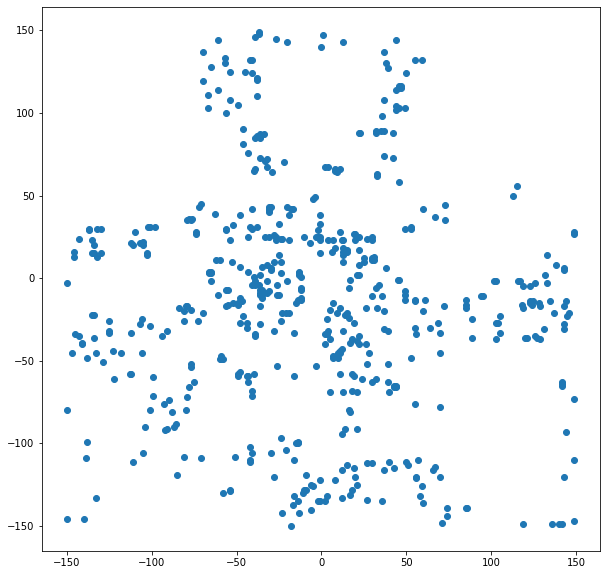

In [29]:
plt.figure(figsize=(10,10
                   ))
plt.scatter(osp.x,osp.y)

In [10]:
osp = pd.read_csv('on_sale_estates.csv')

In [19]:
len(osp)

2252

In [18]:
len(df)

2304

# Get historical parcel sales data

In [11]:
## Query string used to get latest parcel transaction information
mystring = """
{{
  orders (first: 1000 orderBy: updatedAt, orderDirection: asc where: {{ status:sold category:parcel updatedAt_gt:"{0}"}}, subgraphError: allow) {{
 
 
    category
    status
    price
    id
    updatedAt
    nft {{
      owner {{
        id
      }}
      name
      estate {{
        id
      }}
      parcel {{
        id
        x
        y
      }}
     
      owner {{
        id
      }}
    }}
   
  }}
 
}}"""

In [10]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
update = 1

while True:
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(update))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['orders']) <= 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['orders'])
        #unfold a subdict into a series of columns.
        df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        update = df['updatedAt'].max()
        print("last updated at: {}".format(time.strftime('%Y-%m-%d', time.localtime(int(update)))))

#reformat the update date in human-readable datetime format.
df['updatedAt_dt'] = df['updatedAt'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(int(x))) )
df['price'] = df['price'].astype(float)/1e18
df['owner'] = df.owner.apply(lambda x: x['id'])
df['x'] = df.parcel.apply(lambda a: a['x'])
df['y'] = df.parcel.apply(lambda a: a['y'])
df['parcel_id'] = df.parcel.apply(lambda a: a['id'])
df.to_csv('parcel_transactions.csv',index=False)

last updated at: 2018-12-19
last updated at: 2019-03-16
last updated at: 2019-10-21
last updated at: 2020-03-29
last updated at: 2021-01-05
last updated at: 2021-04-14
last updated at: 2021-09-20
last updated at: 2021-12-05
last updated at: 2022-01-31
last updated at: 2022-05-06


# Get historical estate sales data

In [ ]:
# String used to query estate info
mystring = """{{
  orders (first: 1000 orderBy: updatedAt, orderDirection: asc where: {{ status:sold category:estate updatedAt_gt:"{0}"}}, subgraphError: allow) {{
    category
    price
    id
    buyer
    updatedAt
    nft{{
      estate{{
        id
        parcels{{
        id
        x
        y
        }}
      }}
    }}
  }}
}}"""

In [ ]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
update = 1

while True:
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(update))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['orders']) <= 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['orders'])
        #unfold a subdict into a series of columns.
        #df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        update = df['updatedAt'].max()
        print("last updated at: {}".format(time.strftime('%Y-%m-%d', time.localtime(int(update)))))

#reformat the update date in human-readable datetime format.
df['updatedAt_dt'] = df['updatedAt'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(int(x))) )
df['price'] = df['price'].astype(float)/1e18
df['parcels'] = df.nft.apply(lambda x: x['estate']).apply(lambda x: x['parcels']).apply(lambda x: [(int(i['x']),int(i['y'])) for i in x])
df['estate_id'] = df.nft.apply(lambda x: x['estate']).apply(lambda x: x['id'])
df.to_csv('estate_transactions.csv',index=False)

# Get ownerships data

In [ ]:
# String used to query parcel info
mystring = """
{{
  parcels (first: 301 orderBy: x where: {{ y_lte:"{0}" y_gte:"{0}"}} , subgraphError: allow) {{
    id
    tokenId
    owner{{
     id
    }}
    x
    y
    estate{{
     id
    }}
  }}
 
}}"""

In [ ]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
counter = 1

for row_num in range(-150,151):
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(row_num))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['parcels']) < 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['parcels'])
        
        """
        #unfold a subdict into a series of columns.
        df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        """
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        print('first {} rows done!'.format(row_num + 151))
df['owner'] = df.owner.apply(lambda x: x['id'])
df['x'] = df.x.apply(lambda a: int(a))
df['y'] = df.y.apply(lambda a: int(a))
df.to_csv('decentraland_ownership.csv',index=False)